<a href="https://colab.research.google.com/github/prysykes/trevec/blob/main/Copy_of_NSTtrevec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install opencv-python
# !pip install opencv-python-headless
# !pip install matplotlib
# !pip install tf-models-official # !pip install tqdm
# !pip install nltk
# !pip install -U sentence-transformers

In [1]:
import tensorflow as tf
# import tqdm
import random
import csv
import pathlib
import itertools
import collections

import os
import glob
import cv2
import numpy as np
# import remotezip as rz

import tensorflow as tf
import tensorflow_hub as hub
import nltk
nltk.download('wordnet')
#modules to display animation using imageio
# import imageio
# from IPython import display
# from urllib import request
# from tensorflow_docs.vis import embed

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# trevec_vids = '/content/drive/MyDrive/VTT_2023/VTT23.teams.videos'
# print(os.path.isdir(trevec_vids))

trevec_vids = '/content/trevec_videos'
print(os.path.isdir(trevec_vids))

True


In [ ]:
# pathh = trevec_vids

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)


In [3]:
import sys
print(sys.version)
print(tf.__version__)
print(cv2.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.15.0
4.8.0


In [4]:
def format_frame_size(frame, output_size):
    """
        Function to Pad and resize a frame from a video
        Args:
            Frame: An image that needs resizing or padding
            output_size: A tupple of width and height Required pixel size of the padded image
        Return:
            A frame formatted according to the output size
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [5]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=10):
    """
        Creates frames from a video file
        Args:
            video_path: path to the video file
            n_frames: Number of frames to be created per video
            output_size = size of the output_frame
        return:
            An NumPy array of frames in the shape (n_frames, height, width, channels)
    """
    results = []
    src = cv2.VideoCapture(str(video_path))
    file_name = video_path.split('/')[-1]
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT) # total frames in video
    # print("video_length", video_length)
    need_length = 1 + (n_frames - 1) * frame_step
    # print("need_length", need_length)

    if need_length > video_length:
        #if the total frames in the vid is
        #shorter than the needed lenght
        #no need for the offset, start reading at 0
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start +1)
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    #read first frame before skipping by frame_step
    results.append(format_frame_size(frame, output_size))

    #n_frames-1 bc we read the 1st frame already
    for _ in range(n_frames - 1):
        # this loop returns the last frame referenced by the frame step
        # in effect, it it reads frames that are frame_step apart
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frame_size(frame, output_size)
            results.append(frame)
        else:
            #saves a numpy array of all zeros of shape frame.shape
            frame = np.zeros_like(results[0])
            results.append(frame)

    src.release()
    results = np.array(results)[..., [2, 1, 0]]
    return results





In [6]:
video_paths = glob.glob(f"{trevec_vids}/*")
# x = video_paths[0]
# num_part = int(x.split('/')[-1].split('.')[0])
# print(num_part)
print(type(video_paths))
#sort video according to file number
#sort video according to the file name
video_paths = sorted(video_paths, key=lambda x: int(x.split('/')[-1].split('.')[0]))


<class 'list'>


In [7]:
n = 0
for file in video_paths:
    if n > 2:
        break
    print(file)
    n +=1

/content/trevec_videos/1.webm
/content/trevec_videos/2.webm
/content/trevec_videos/3.webm


In [8]:
trevec_sample_vid = frames_from_video_file(video_paths[0], 20)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

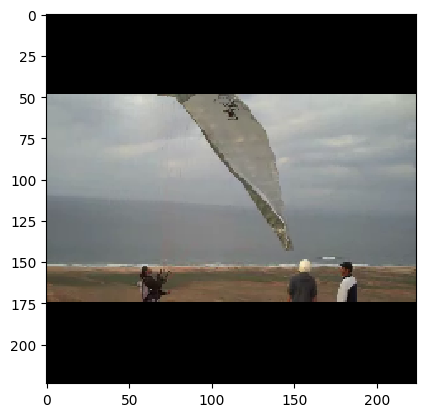

In [10]:
plt.imshow(trevec_sample_vid[0], interpolation='nearest')
plt.show()

In [11]:
print(len(video_paths))

100


In [12]:
class FrameGenerator:
    def __init__(self, video_paths, n_frames, training=False):
        """
            Returns a set of frames from a video in the video_paths list

            Args:
            video_paths: a list of path to videos
            n_frames: Number of frames
            training: A boolean to determine if a training dataset should be created
        """

        self.video_paths = video_paths
        self.n_frames = n_frames
        self.training = training

    def __call__(self):
        """
            gets called and yields a set of frames
            each time the instance of the class is called
        """
        video_paths = self.video_paths
        # print(type(video_paths))
        if self.training:
            random.shuffle(video_paths)

        for path in video_paths:
            video_frames = frames_from_video_file(path, self.n_frames)
            file_name = path.split('/')[-1]
            # print(file_name, "filfile")
            yield video_frames, file_name

In [13]:
# fg = FrameGenerator(video_paths, 20, training=False)
# fg = fg()



In [18]:
# _iter = iter(fg)

In [22]:
# next(_iter)


(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [14]:
# frames, file_name = next(iter(fg))
# print(file_name)
# frames, file_name = next(iter(fg))
# print(file_name)
# frames, file_name = next(iter(fg))
# print(file_name)
# frames, file_name = next(iter(fg))
# print(file_name)
# frames, file_name = next(iter(fg))
# print(file_name)
# frames, file_name = next(iter(fg))
# print(file_name)

1.webm
2.webm
3.webm
4.webm
5.webm
6.webm


In [15]:
frames.shape
print(file_name)

6.webm


In [23]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype=tf.float32), tf.TensorSpec(shape = None, dtype=tf.string))

dataset = tf.data.Dataset.from_generator(FrameGenerator(video_paths, 20, training=False), output_signature=output_signature)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
# idx, sequence = next(iter(dataset))
# print(idx.numpy())

In [25]:
BATCH_SIZE =10 #change the batch size acording to what the GPU can handle

In [26]:
inference_datasets = dataset.batch(BATCH_SIZE)

In [70]:
sample_inference_dataset = next(iter(inference_datasets))
#return a tupple containing a numpy array of frames belonging to each video with size of BATCH_SIZE
# and a list of their corresponding file name



In [75]:
import math
total_batch = math.ceil(len(video_paths)/BATCH_SIZE)
print(total_batch)

10


In [76]:
sample_inference_dataset = []
itr = iter(inference_datasets)
for x in range(total_batch):
  print(f'currenly at batch - {x}')

  cur_sample_inference_dataset = next(itr)
  sample_inference_dataset.append(cur_sample_inference_dataset)

currenly at batch - 0
currenly at batch - 1
currenly at batch - 2
currenly at batch - 3
currenly at batch - 4
currenly at batch - 5
currenly at batch - 6
currenly at batch - 7
currenly at batch - 8
currenly at batch - 9


In [77]:
print(sample_inference_dataset[0][0][0])

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [78]:
print("len(sample_inference_dataset)", len(sample_inference_dataset))
#selects first item in batch, then select all frames (20, 224,224, 3) from first batch then selects the first item
print("sample_inference_dataset[0][0][0].shape", sample_inference_dataset[0][0][0].shape)
#selects first item in batch, then select all class strings from first batch then selects the first item
print("sample_inference_dataset[1]", (sample_inference_dataset[0][1][0]))
print("sample_inference_dataset[0][0] shape", (sample_inference_dataset[0][0].shape))
# tf_string = tf.constant(sample_inference_dataset[1][0])
string_value = sample_inference_dataset[0][1][0].numpy().decode('utf-8')
print("sample_inference_dataset[0][1][0]]", string_value)

len(sample_inference_dataset) 10
sample_inference_dataset[0][0][0].shape (20, 224, 224, 3)
sample_inference_dataset[1] tf.Tensor(b'1.webm', shape=(), dtype=string)
sample_inference_dataset[0][0] shape (10, 20, 224, 224, 3)
sample_inference_dataset[0][1][0]] 1.webm


In [56]:
print(len(sample_inference_dataset[0]))

2


In [ ]:
# id = 'a2'
# mode = 'base'
# version = '3'
# hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
# model = hub.load(hub_url)

In [57]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

In [ ]:
# print(KINETICS_600_LABELS)

In [ ]:
# sig = model.signatures['serving_default']
# print(sig.pretty_printed_signature())

In [ ]:
# sig(image = sample_inference_dataset[0])

In [ ]:
# print(sample_inference_dataset[0].shape)

In [ ]:
# %%time
# logits = sig(image=sample_inference_dataset[0])
# logits = logits['classifier_head'][0]
# print(logits.shape)
# print()

In [58]:
#@title
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS, capture_output=False):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  # if capture_output == True:
  #   yield tuple(zip(top_labels, top_probs))

  # else:
  yield tuple(zip(top_labels, top_probs))


In [ ]:
# for idx in range(len(sample_inference_dataset[0])):
#   if idx > 2:
#     break
#   file_name = sample_inference_dataset[1][idx]
#   cur_inference_dataset = sample_inference_dataset[0][idx]
#   cur_inference_dataset = cur_inference_dataset[tf.newaxis, ...]
#   logits = sig(image=cur_inference_dataset)
#   logits = logits['classifier_head'][0]
#   probs = tf.nn.softmax(logits, axis=-1)
#   top_k_labels = get_top_k(probs)
#   print(top_k_labels)
#   # file_name = cur_tupple[1][idx]
#   # print("cur_tupple[1]", cur_tupple[1])
#   print("file_name", file_name)

In [ ]:
# probs = tf.nn.softmax(logits, axis=-1)
# top_k_labels = list(get_top_k(probs))
# print(top_k_labels)
# close_labels = {}
# for idx, lab_conf in enumerate(top_k_labels):
#   # print(lab_conf[1]-1)
#   if idx == 0:
#     close_labels[f'{lab_conf[0]}'] = lab_conf[1]
#   else:
#     close_labels_keys = list(close_labels.keys())
#     best_class = close_labels_keys[0]
#     # print(type(float(close_labels[best_class])), type(float(lab_conf[1])))
#     print(close_labels[best_class]-lab_conf[1])
#     # if close_labels[best_class] - lab_conf[1] > 0.4:
#     #   print('yes')
#   # print(best_class)

# print(close_labels)
# # for label, p in get_top_k(probs):

# #   print(f'{label:20s}: {p:.3f}')

#Stream version of the model

In [35]:
#time
id = 'a2'
mode = 'stream'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

In [36]:
list(model.signatures.keys())

['call', 'init_states']

In [37]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
lines = lines[:10]
lines.append('      ...')
print('.\n'.join(lines))

Input Parameters:.
  input_shape (KEYWORD_ONLY): TensorSpec(shape=(5,), dtype=tf.int32, name='input_shape').
Output Type:.
  Dict[['state/b0/l1/stream_buffer', TensorSpec(shape=(None, 2, None, None, 40), dtype=tf.float32, name='state/b0/l1/stream_buffer')], ['state/b4/l3/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 480), dtype=tf.float32, name='state/b4/l3/pool_buffer')], ['state/b4/l5/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 480), dtype=tf.float32, name='state/b4/l5/pool_buffer')], ['state/b1/l0/stream_buffer', TensorSpec(shape=(None, 2, None, None, 96), dtype=tf.float32, name='state/b1/l0/stream_buffer')], ['state/b4/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 384), dtype=tf.float32, name='state/b4/l2/pool_buffer')], ['state/b2/l0/stream_buffer', TensorSpec(shape=(None, 4, None, None, 240), dtype=tf.float32, name='state/b2/l0/stream_buffer')], ['state/b2/l3/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 192), dtype=tf.float32, name='state/b2/l3/pool_buffer')], ['state/b

In [61]:
print(sample_inference_dataset[0][0].shape)
initial_state_tensor = sample_inference_dataset[0][0][0][tf.newaxis, ...] # takes a video file (20,224, 224, 3) and adds a new axis eg (1, 20, 224, 224, 3)
print(initial_state_tensor.shape)

(10, 20, 224, 224, 3)
(1, 20, 224, 224, 3)


In [62]:
initial_state = model.init_states(initial_state_tensor.shape)

In [63]:
type(initial_state)

dict

In [64]:
list(sorted(initial_state.keys()))[:5]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer']

In [69]:
print(sample_inference_dataset[0][0][0].shape)

(20, 224, 224, 3)


In [70]:
inputs = initial_state.copy()
inputs['image'] = initial_state_tensor[0:1, ...]

In [72]:
# warmup
model(inputs);

In [71]:
print(len(initial_state_tensor[0]))

20


In [ ]:
# initial_state = model.init_states(initial_state_tensor.shape)
# state = initial_state.copy()
# all_logits =[]
# # warmup
# # model(inputs)
# for idx in range(len(initial_state_tensor[0])):

#   cur_input_tensor = sample_inference_dataset[0][idx]
#   print("cur_input_tensor", cur_input_tensor.shape)
#   cur_input_tensor = cur_input_tensor[tf.newaxis]
#   # print(cur_input_tensor.shape)
#   print('cur_input_tensor.shape', cur_input_tensor.shape)

#   file_name = sample_inference_dataset[1][idx]

#   inputs['image'] = cur_input_tensor[0:1, ...]
#   #add a new axis, select first from from the array of frames, then selet the whole height, width and channel axis
#   logits, new_state = model(inputs)
#   logits = logits[0]
#   probs = tf.nn.softmax(logits, axis=-1)
#   initial_state = model.init_states(initial_state_tensor.shape)
#   state = initial_state.copy()
#   top_k_labels = tuple(get_top_k(probs, capture_output=True))
#   # print(len(top_k_labels[0]))
#   # print(top_k_labels)
#   string_value = file_name.numpy().decode('utf-8')
#   all_logits.append((logits, string_value))

#   print("file_name", string_value)

In [79]:
print(len(sample_inference_dataset))
print(total_batch)

10
10


In [92]:
initial_state = model.init_states(initial_state_tensor.shape)
state = initial_state.copy()
all_logits =[] # contains tupple inference logits and file name for each batch of frames in sample_inference_dataset
# warmup
# model(inputs)
pointer = 0

while pointer < total_batch:
  if len(sample_inference_dataset[pointer]) == 0:
    break
  present_batch = []
  # print(pointer, len(sample_inference_dataset[pointer]), sample_inference_dataset[pointer][0].shape, len(sample_inference_dataset[pointer][0]) )
  for idx in range(len(sample_inference_dataset[pointer][0])):

    cur_input_tensor = sample_inference_dataset[pointer][0][idx] #returns a list of frames
    cur_input_tensor = cur_input_tensor[tf.newaxis]
    # print('cur_input_tensor.shape', cur_input_tensor.shape)

    file_name = sample_inference_dataset[pointer][1][idx]
    # print('file_name', file_name)

    inputs['image'] = cur_input_tensor[0:1, ...]
    #add a new axis, select first from from the array of frames, then selet the whole height, width and channel axis
    logits, new_state = model(inputs)
    logits = logits[0]
    probs = tf.nn.softmax(logits, axis=-1)
    initial_state = model.init_states(initial_state_tensor.shape)
    state = initial_state.copy()
    top_k_labels = tuple(get_top_k(probs, capture_output=True))
    # print(len(top_k_labels[0]))
    # print(top_k_labels)
    string_value = file_name.numpy().decode('utf-8')
    present_batch.append((logits, string_value))

    print("file_name", string_value)
  all_logits.append(present_batch)
  pointer +=1



file_name 1.webm
file_name 2.webm
file_name 3.webm
file_name 4.webm
file_name 5.webm
file_name 6.webm
file_name 7.webm
file_name 8.webm
file_name 9.webm
file_name 10.webm
file_name 11.webm
file_name 12.webm
file_name 13.webm
file_name 14.webm
file_name 15.webm
file_name 16.webm
file_name 17.webm
file_name 18.webm
file_name 19.webm
file_name 20.webm
file_name 21.webm
file_name 22.webm
file_name 23.webm
file_name 24.webm
file_name 25.webm
file_name 26.webm
file_name 27.webm
file_name 28.webm
file_name 29.webm
file_name 30.webm
file_name 31.webm
file_name 32.webm
file_name 33.webm
file_name 34.webm
file_name 35.webm
file_name 36.webm
file_name 37.webm
file_name 38.webm
file_name 39.webm
file_name 40.webm
file_name 41.webm
file_name 42.webm
file_name 43.webm
file_name 44.webm
file_name 45.webm
file_name 46.webm
file_name 47.webm
file_name 48.webm
file_name 49.webm
file_name 50.webm
file_name 51.webm
file_name 52.webm
file_name 53.webm
file_name 54.webm
file_name 55.webm
file_name 56.webm
f

In [ ]:
# #previous implementation

# initial_state = model.init_states(initial_state_tensor.shape)
# state = initial_state.copy()
# all_logits =[]
# # warmup
# # model(inputs)
# for idx in range(len(sample_inference_dataset[0])):

#   cur_input_tensor = sample_inference_dataset[0][idx] #returns a list of frames
#   cur_input_tensor = cur_input_tensor[tf.newaxis]
#   # print(cur_input_tensor.shape)

#   file_name = sample_inference_dataset[1][idx]

#   inputs['image'] = cur_input_tensor[0:1, ...]
#   #add a new axis, select first from from the array of frames, then selet the whole height, width and channel axis
#   logits, new_state = model(inputs)
#   logits = logits[0]
#   probs = tf.nn.softmax(logits, axis=-1)
#   initial_state = model.init_states(initial_state_tensor.shape)
#   state = initial_state.copy()
#   top_k_labels = tuple(get_top_k(probs, capture_output=True))
#   # print(len(top_k_labels[0]))
#   # print(top_k_labels)
#   string_value = file_name.numpy().decode('utf-8')
#   all_logits.append((logits, string_value))

#   # print("file_name", string_value)

In [96]:
print(all_logits[0][0][1])

1.webm


In [112]:
pointer = 0
initial_state = model.init_states(initial_state_tensor.shape)
state = initial_state.copy()

topk_labels_and_filename = []

while pointer < total_batch:
  # print(len(sample_inference_dataset[pointer][0]), len(all_logits[pointer]))
  for idx, logits_filename in enumerate(all_logits[pointer]):
    # print(logits_filename[1])
    cur_input_tensor_rnn = sample_inference_dataset[pointer][0][idx]
    # print(len(cur_input_tensor_rnn))
    for n in range(len(sample_inference_dataset[pointer][0][idx])):
      inputs = state

      inputs['image'] = cur_input_tensor_rnn[tf.newaxis, n:n+1, ...]
      result, state = model(inputs)
    probabilities = tf.nn.softmax(logits_filename[0], axis=-1)
    top_k_labels = tuple(get_top_k(probabilities))
    # string_value = file_name.numpy().decode('utf-8')
    topk_labels_and_filename.append((top_k_labels, logits_filename[1]))
    print(top_k_labels, logits_filename[1])
  pointer +=1


((('land sailing', 0.7973136), ('paragliding', 0.018208582), ('flying kite', 0.017316513), ('windsurfing', 0.010917082), ('sailing', 0.005375301)),) 1.webm
((('shuffling feet', 0.33091667), ('jogging', 0.2275203), ('jumpstyle dancing', 0.089687705), ('delivering mail', 0.0241667), ('tap dancing', 0.012858744)),) 2.webm
((('shaking hands', 0.980253), ('swing dancing', 0.0054294625), ('punching person (boxing)', 0.0036981783), ('rock scissors paper', 0.0027436845), ('playing hand clapping games', 0.0013201013)),) 3.webm
((('skateboarding', 0.65953326), ('longboarding', 0.11889075), ('hurdling', 0.06789276), ('hockey stop', 0.0451897), ('triple jump', 0.018385356)),) 4.webm
((('lifting hat', 0.5182754), ('checking tires', 0.08321269), ('playing darts', 0.0726137), ('changing wheel (not on bike)', 0.05383953), ('gold panning', 0.041914914)),) 5.webm
((('marching', 0.10461076), ('picking fruit', 0.07874385), ('tai chi', 0.04526224), ('playing trombone', 0.03925207), ('geocaching', 0.0373706

In [ ]:
# #old implementation
# initial_state = model.init_states(initial_state_tensor.shape)
# state = initial_state.copy()

# topk_labels_and_filename = []
# for idx, logits_filename in enumerate(all_logits):
#   cur_input_tensor_rnn = sample_inference_dataset[0][idx]

#   for n in range(len(sample_inference_dataset[0][idx])):
#       inputs = state


#       inputs['image'] = cur_input_tensor_rnn[tf.newaxis,n:n+1, ...]
#       result, state = model(inputs)

#   probabilities = tf.nn.softmax(logits_filename[0], axis=-1)
#   top_k_labels = tuple(get_top_k(probabilities))
#   # string_value = file_name.numpy().decode('utf-8')
#   topk_labels_and_filename.append((top_k_labels, logits_filename[1]))
#   # print(top_k_labels, logits_filename[1])

((('flying kite', 0.445792), ('paragliding', 0.3267446), ('kitesurfing', 0.07161708), ('skydiving', 0.027299292), ('snowkiting', 0.022540022)),) 1.webm
((('shuffling feet', 0.39762908), ('jogging', 0.19179296), ('jumpstyle dancing', 0.0858126), ('delivering mail', 0.026902696), ('walking through snow', 0.012170405)),) 2.webm
((('shaking hands', 0.980253), ('swing dancing', 0.0054294625), ('punching person (boxing)', 0.0036981816), ('rock scissors paper', 0.002743683), ('playing hand clapping games', 0.0013201013)),) 3.webm
((('skateboarding', 0.659533), ('longboarding', 0.11889083), ('hurdling', 0.06789277), ('hockey stop', 0.045189794), ('triple jump', 0.018385375)),) 4.webm
((('lifting hat', 0.2827721), ('checking tires', 0.06337075), ('playing gong', 0.06235024), ('playing darts', 0.058820244), ('changing wheel (not on bike)', 0.021670716)),) 5.webm


In [ ]:
# # print(np.argmax(all_logits[0][0])) # location of the maximum value
# # print(all_logits[0][0][251])
# for logits, file_name in all_logits:
#   print((logits.shape), file_name) #all logits are 600 in len

In [ ]:
# sample_inference_dataset[0][0]

Generate Embeddings for the senstences and calculate the distancd between the embeddings

In [ ]:
from sentence_transformers import SentenceTransformer, util
embedding_model = SentenceTransformer('all-MiniLM-L6-V2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
# embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
# with open('videos_table.csv', 'w') as videos_table:
#   headernames=['file_name', 'best_class', 'best_confidence', 'class_embeddings']
#   writer = csv.DictWriter(videos_table, headernames)
#   writer.writeheader()

# with open('other_classes_table.csv', 'w') as classes_table:
#   headernames=['class_name', 'class_confidence', 'file_name']
#   writer = csv.DictWriter(classes_table, headernames)
#   writer.writeheader()

In [ ]:
video_table_csv_header = ['file_name', 'best_class', 'best_confidence', 'class_embeddings']
other_classes_table_csv_header = ['class_name', 'class_confidence', 'file_name']

In [ ]:
for idx, labels_filename in enumerate(topk_labels_and_filename):
  # print(f'labels_filename {labels_filename}')
  file_name = labels_filename[-1] #build full path to this video filename using parent dir
  best_class = labels_filename[0][0][0][0]
  best_class_str_enc = embedding_model.encode(best_class)
  print('best_class_str_enc', best_class_str_enc, '\n', 'best_class_str_enc shape:', best_class_str_enc.shape)
  best_class_conf = labels_filename[0][0][0][1]
  rest_4_class_conf = labels_filename[0][0][1:]
  with open('videos_table.csv', 'a') as videos_table_file:
    videos_table_writer = csv.writer(videos_table_file)
    if idx == 0:
      videos_table_writer.writerow(video_table_csv_header)
      videos_table_writer.writerow([file_name, best_class, best_class_conf, best_class_str_enc])
    else:
      videos_table_writer.writerow([file_name, best_class, best_class_conf, best_class_str_enc])
  for idx_2, class_conf in enumerate(rest_4_class_conf):
    with open('other_classes_table.csv', 'a') as classes_table_file:
      classes_table_writer = csv.writer(classes_table_file)
      if idx==0  and idx_2==0:
        classes_table_writer.writerow(other_classes_table_csv_header)
        classes_table_writer.writerow([class_conf[0], class_conf[1], file_name])
        # print(f'idx {idx}-{idx_2} \t cur_row {[class_conf[0], class_conf[1], file_name]}')
      else:
        classes_table_writer.writerow([class_conf[0], class_conf[1], file_name])
        # print(f'idx {idx} \t cur_row {[class_conf[0], class_conf[1], file_name]}')


  # print(idx, '\n', file_name, '\n', best_class_conf, '\n', rest_4_class_conf)

best_class_str_enc [ 1.97031088e-02  6.34348020e-02 -5.53272404e-02  3.42106335e-02
 -4.41124663e-02  9.20514669e-03  1.13892205e-01 -3.87769043e-02
 -1.91940984e-03  2.30451711e-02  6.55183569e-02 -2.03129407e-02
 -1.12530552e-01 -2.32368521e-02  1.43749202e-02  1.18214786e-01
 -5.81338406e-02 -5.39784990e-02 -6.75041601e-02  1.67966224e-02
 -1.17787411e-02  6.84228018e-02  2.35441653e-03  5.03665619e-02
 -2.20444500e-02  2.71624532e-02 -4.26753834e-02  2.99742203e-02
  1.65343620e-02 -4.32938747e-02  2.56197304e-02  8.59269053e-02
 -7.24546984e-02  3.22186798e-02 -9.76739898e-02  1.97733864e-02
  1.81963407e-02 -2.12798808e-02 -1.54247293e-02 -9.75875836e-03
  2.37002466e-02 -2.27995813e-02  1.54484967e-02  3.88949811e-02
 -1.72414202e-02  6.70989305e-02  8.61339420e-02  2.58293413e-02
  6.30141869e-02  1.84709150e-02 -7.01361820e-02 -4.54497375e-02
 -1.92254614e-02 -6.33126423e-02  1.18434332e-01 -5.25672641e-03
  2.53648609e-02 -1.79113280e-02 -3.14509473e-03 -6.74602687e-02
 -1.21

In [ ]:
print(len(topk_labels_and_filename))

8


In [ ]:
for labels_filename in topk_labels_and_filename:
  sim_output = {}
  file_name = labels_filename[-1]
  sim_output.setdefault(file_name, {})
  for idx, label_class in enumerate(labels_filename[0][0]):
    if idx == 0:
      #sets the best class as the first member of the list of tupples
      _class = label_class[0]
      _conf = label_class[1]
      sim_output[file_name].setdefault('best_class', (_class, _conf))

    else:
      cur_class_str = label_class[0]
      cur_conf = label_class[1]
      best_class_str = sim_output[file_name]['best_class'][0]
      best_class_conf = sim_output[file_name]['best_class'][1]
      best_class_str_enc = embedding_model.encode(best_class_str)
      cur_class_str_enc = embedding_model.encode(cur_class_str)
      cosine_score = util.cos_sim(best_class_str_enc, cur_class_str_enc)

      print(f"best_class_str: {best_class_str} \t best_class_conf {best_class_conf} \t cur_class_str: \t {cur_class_str} \t cur_conf {cur_conf} cosine_score: {cosine_score}")



  print(sim_output)

best_class_str: singing 	 best_class_conf 0.22410693764686584 	 cur_class_str: 	 beatboxing 	 cur_conf 0.15179988741874695 cosine_score: tensor([[0.3256]])
best_class_str: singing 	 best_class_conf 0.22410693764686584 	 cur_class_str: 	 answering questions 	 cur_conf 0.08556041121482849 cosine_score: tensor([[0.2972]])
best_class_str: singing 	 best_class_conf 0.22410693764686584 	 cur_class_str: 	 news anchoring 	 cur_conf 0.024441832676529884 cosine_score: tensor([[0.1666]])
best_class_str: singing 	 best_class_conf 0.22410693764686584 	 cur_class_str: 	 laughing 	 cur_conf 0.02402876876294613 cosine_score: tensor([[0.3352]])
{'2292.webm': {'best_class': ('singing', 0.22410694)}}
best_class_str: braiding hair 	 best_class_conf 0.561708390712738 	 cur_class_str: 	 fixing hair 	 cur_conf 0.07904480397701263 cosine_score: tensor([[0.6302]])
best_class_str: braiding hair 	 best_class_conf 0.561708390712738 	 cur_class_str: 	 dyeing hair 	 cur_conf 0.07032710313796997 cosine_score: tensor

Mounted at /content/drive


In [ ]:
THRESHOLDS = [0.25, 0.5, 0.75]

In [ ]:
for class_conf_filename in topk_labels_and_filename:
  metric_results = {}
  file_name = class_conf_filename[-1]
  # sim_output.setdefault(file_name, {})
  metric_results.setdefault(file_name, {})
  # print("class_conf_filename[0][0]", class_conf_filename[0][0])
  top_3 = list(class_conf_filename[0][0][:3])
  # print(top_3)

  # print(metric_results)

  for idx, class_conf in enumerate(class_conf_filename[0][0]):
    if idx == 0:
      #sets the best class as the first member of the list of tupples
      _class = class_conf[0]
      _conf = class_conf[1]
      metric_results[file_name].setdefault('best_class', (_class, _conf))
      metric_results[file_name].setdefault('top_3', top_3)
      metric_results[file_name].setdefault('similarity_scores', {})


    else:
      # print("idx", {idx})

      for threshold in THRESHOLDS:
        cur_class_str = class_conf[0]
        cur_conf = class_conf[1]
        best_class_str = metric_results[file_name]['best_class'][0]
        best_class_conf = metric_results[file_name]['best_class'][1]
        best_class_str_enc = embedding_model.encode(best_class_str)
        cur_class_str_enc = embedding_model.encode(cur_class_str)
        cosine_score = float(util.cos_sim(best_class_str_enc, cur_class_str_enc))
        # print("cosine score", cosine_score)
        if cosine_score > threshold:

          if metric_results[file_name]['similarity_scores'].get(threshold) == None:
            # print('yes and None', threshold)
            metric_results[file_name]['similarity_scores'].setdefault(threshold, [])
            class_conf_score_tup = (cur_class_str, cur_conf, cosine_score)
            metric_results[file_name]['similarity_scores'][threshold].append(class_conf_score_tup)
          else:
            # print('else and None', threshold)
            class_conf_score_tup = (cur_class_str, cur_conf, cosine_score)
            metric_results[file_name]['similarity_scores'][threshold].append(class_conf_score_tup)


        # print(f"best_class_str: {best_class_str} \t best_class_conf {best_class_conf} \t cur_class_str: \t {cur_class_str} \t cur_conf {cur_conf} cosine_score: {cosine_score}")

  print(metric_results)

{'20.webm': {'best_class': ('playing netball', 0.27098614), 'top_3': [('playing netball', 0.27098614), ('playing basketball', 0.05729753), ('playing volleyball', 0.029534493)], 'similarity_scores': {0.25: [('playing basketball', 0.05729753, 0.682671070098877), ('playing volleyball', 0.029534493, 0.7083607912063599), ('skipping rope', 0.027461011, 0.45699837803840637), ('dribbling basketball', 0.01886825, 0.5096060037612915)], 0.5: [('playing basketball', 0.05729753, 0.682671070098877), ('playing volleyball', 0.029534493, 0.7083607912063599), ('dribbling basketball', 0.01886825, 0.5096060037612915)]}}}
{'25.webm': {'best_class': ('roasting pig', 0.17541447), 'top_3': [('roasting pig', 0.17541447), ('shaking hands', 0.10426599), ('barbequing', 0.06106781)], 'similarity_scores': {0.25: [('barbequing', 0.06106781, 0.512639582157135), ('headbanging', 0.040890414, 0.25592947006225586)], 0.5: [('barbequing', 0.06106781, 0.512639582157135)]}}}
{'35.webm': {'best_class': ('card throwing', 0.059

In [ ]:
for class_conf in top_k_labels:
  print(class_conf)

(('shuffling feet', 0.40066084), ('jogging', 0.16968915), ('jumpstyle dancing', 0.13156785), ('delivering mail', 0.014214353), ('tap dancing', 0.010723671))


In [ ]:
# print(top_k_labels)
close_labels = {}
for idx, lab_conf in enumerate(top_k_labels[0]):
  if idx == 0:
    close_labels.setdefault(lab_conf[0].replace(' ', '_'), lab_conf[1])
  else:
    best_class = list(close_labels.keys())[0]
    best_class_conf = close_labels[best_class]
    cur_class = lab_conf[0].replace(' ', '_')
    cur_class_conf = lab_conf[1]
    best_class =
    if (best_class_conf - cur_class_conf) < 0.2:
      close_labels.setdefault(cur_class, cur_class_conf)


    print(f"best_class: {best_class} \t best_class_conf {best_class_conf} \t cur_class {cur_class} \t cur_class_conf {cur_class_conf}")



print(close_labels)

best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class jogging 	 cur_class_conf 0.2396440953016281
best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class jumpstyle_dancing 	 cur_class_conf 0.11431951820850372
best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class delivering_mail 	 cur_class_conf 0.02315945364534855
best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class hopscotch 	 cur_class_conf 0.01479418482631445
{'shuffling_feet': 0.25325164, 'jogging': 0.2396441, 'jumpstyle_dancing': 0.11431952}


In [ ]:
def check_close_scores(top_k_labels):
  close_labels = {}
  for idx, lab_conf in enumerate(top_k_labels[0]):
    if idx == 0:
      close_labels.setdefault(lab_conf[0], lab_conf[1])
    else:
      best_class = list(close_labels.keys())[0]
      best_class_conf = close_labels[best_class]
      cur_class = lab_conf[0]
      cur_class_conf = lab_conf[1]
      if (best_class_conf - cur_class_conf) < 0.2:
        close_labels.setdefault(cur_class, cur_class_conf)

In [ ]:
from nltk.corpus import wordnet as wn
# from nltk.wup import wup_similarity

In [ ]:
# print(top_k_labels)

close_labels = {}
for idx, lab_conf in enumerate(top_k_labels[0]):
  if idx == 0:
    close_labels.setdefault(lab_conf[0], lab_conf[1])
  else:
    best_class = list(close_labels.keys())[0]
    best_class_conf = close_labels[best_class]
    cur_class = lab_conf[0]
    cur_class_conf = lab_conf[1]

    best_class_tokens = best_class.split()
    cur_class_tokens = cur_class.split()
    # print(f"best_class_tokens: {best_class_tokens} \t cur_class_tokens: {cur_class_token}")

    for token1 in best_class_tokens:
      max_similairity = 0
      for token2 in cur_class_tokens:
        print(f"token1 {token1} \t token2 {token2}")
        synsets_token1 = list(wn.synsets('mad'))[0]
        synsets_token2 = list(wn.synsets('crazy'))[0]
        print(synsets_token1, synsets_token2)
        similarity = synsets_token1.wup_similarity(synsets_token2)
        if similarity > max_similairity:
          max_similairity = similarity
    print(f"max_similarity {max_similairity}")

        #compute Wu-Palmer Similarity for each pair of synsets
        # for synset1 in synsets_token1:
        #   for synset2 in synsets_token2:
        #     similarity =

    # if ' ' not in best_class:
    #   try:
    #     #TODO: replace mad with best_class
    #     best_class_syn = wn.synsets('jogging')
    #     best_class_syn = best_class_syn[0]
    #   except Exception as e:
    #     print(e)
    #   print('yes')
    # else:
    #   similarity_score = nltk.similarity.cosine_similarity(best_class, cur_class)
    #   print(similarity_score)


    # if ' ' not in cur_class:
    #   #TODO: replace mad with cur_class
    #   try:
    #     cur_class_syn = wn.synsets('runing')
    #     cur_class_syn = cur_class_syn[0]
    #   except Exception as e:
    #     print(e)
    #   print('yes')

    # else:
    #   pass

    # print(best_class_syn.wup_similarity(cur_class_syn))


    # try:
    #   best_class_syn = wn.synsets('mad')
    #   cur_class_syn = wn.synsets('mad')

    #   best_class_syn = best_class_syn[0]
    #   cur_class_syn = cur_class_syn[0]
    #   print(best_class_syn.wup_similarity(cur_class_syn))
    #   # print(best_class_syn, cur_class_syn)
    # except Exception as e:
    #   print(e)
    # # print(best_class_syn.wup_)




# print(close_labels)

token1 shuffling 	 token2 jogging
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 jogging
Synset('huffy.s.02') Synset('crazy.n.01')
max_similarity 0.16666666666666666
token1 shuffling 	 token2 jumpstyle
Synset('huffy.s.02') Synset('crazy.n.01')
token1 shuffling 	 token2 dancing
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 jumpstyle
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 dancing
Synset('huffy.s.02') Synset('crazy.n.01')
max_similarity 0.16666666666666666
token1 shuffling 	 token2 delivering
Synset('huffy.s.02') Synset('crazy.n.01')
token1 shuffling 	 token2 mail
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 delivering
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 mail
Synset('huffy.s.02') Synset('crazy.n.01')
max_similarity 0.16666666666666666
token1 shuffling 	 token2 hopscotch
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 hopscotch
Synset('huffy.s.02') Synset('crazy.n.01')
max_s

In [ ]:
for label, p in get_top_k(probabilities[-1]):
  print(f'{label:20s}: {p:.3f}')

slacklining         : 0.868
golf chipping       : 0.024
golf driving        : 0.012
tightrope walking   : 0.004
tiptoeing           : 0.003


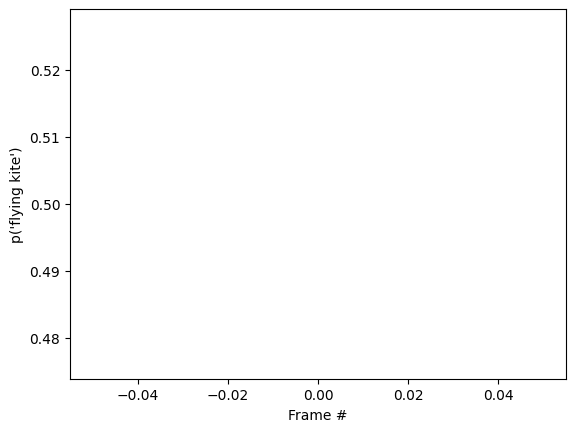

In [ ]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

In [ ]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.358
mowing lawn         : 0.128
slacklining         : 0.091
golf driving        : 0.090
golf putting        : 0.075


++++++++++++++++++++++==================

In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

photobombing        : 0.256
waving hand         : 0.233
sign language interpreting: 0.043
shaving head        : 0.041
stretching arm      : 0.025


photobombing        : 0.256
waving hand         : 0.233
sign language interpreting: 0.043
shaving head        : 0.041
stretching arm      : 0.025    #for frame size 20

In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

waving hand         : 0.279
photobombing        : 0.178
shaving head        : 0.045
cleaning windows    : 0.043
playing darts       : 0.023


In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

waving hand         : 0.354
photobombing        : 0.283
shaving head        : 0.025
sign language interpreting: 0.020
stretching arm      : 0.018


waving hand         : 0.279
photobombing        : 0.178
shaving head        : 0.045
cleaning windows    : 0.043
playing darts       : 0.023   # for frame size 10